# ArchR Integration

scATAC + scRNA integration using ArchR.

**TODO**: Run with right set of cells!! And use SnapATAC dim reduction!

In [28]:
library(Seurat)
library(ArchR)
library(rtracklayer)
library(patchwork)

In [4]:
addArchRThreads(threads = 32) 

Setting default number of Parallel threads to 32.



In [5]:
addArchRGenome("hg38")

Setting default genome to Hg38.



## Load Data

In [6]:
ArrowFiles = c('D0.arrow',
               'D2.arrow',
               'D4.arrow',
               'D6.arrow',
               'D8.arrow',
               'D10.arrow',
               'D12.arrow',
               'D14.arrow')
#              'H1.arrow')

In [7]:
archr_proj <- ArchRProject(
  ArrowFiles = paste("/srv/scratch/surag/scATAC-reprog/arrow/", ArrowFiles, sep=''), 
  outputDirectory = "./tmp/",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

### Seurat Object

In [8]:
rna = readRDS("./sessions/20200913_n27632/seurat.rds")
rna$tech = "rna"

## ArchR Prep

In [13]:
peak_set = import("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
peak_set

GRanges object with 803958 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   97145605-97145864      *
       [2]     chr1     7538149-7538363      *
       [3]     chr1   93196679-93196894      *
       [4]     chr1 187577714-187577913      *
       [5]     chr1   53278066-53278265      *
       ...      ...                 ...    ...
  [803954]     chrY     7500308-7500509      *
  [803955]     chrY     7447985-7448191      *
  [803956]     chrY   14733641-14733856      *
  [803957]     chrY   12662453-12662752      *
  [803958]     chrY   12681581-12681865      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [14]:
# add peaks matrix 
archr_proj = addPeakSet(archr_proj, peak_set)
archr_proj <- addPeakMatrix(archr_proj)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-7321374d86d4-Date-2020-09-23_Time-10-11-36.log
If there is an issue, please report to github with logFile!

2020-09-23 10:11:37 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-7321374d86d4-Date-2020-09-23_Time-10-11-36.log



In [15]:
getAvailableMatrices(archr_proj)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [16]:
archr_proj <- addIterativeLSI(
    ArchRProj = archr_proj,
    useMatrix = "PeakMatrix", 
    name = "IterativeLSI", 
    iterations = 2, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.2), 
        sampleCells = 10000, 
        n.start = 10
    ), 
    varFeatures = 25000, 
    dimsToUse = 1:30
)

2020-09-23 10:21:28 : Computing LSI, 3.405 mins elapsed.

2020-09-23 10:23:34 : Finished Running IterativeLSI, 5.514 mins elapsed.



In [17]:
archr_proj <- addUMAP(ArchRProj = archr_proj, reducedDims = "IterativeLSI")

10:24:38 UMAP embedding parameters a = 0.7669 b = 1.223

10:24:38 Read 76727 rows and found 30 numeric columns

10:24:38 Using Annoy for neighbor search, n_neighbors = 40

10:24:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:24:51 Writing NN index file to temp file /tmp/Rtmp9WZouP/file732150eaa694

10:24:51 Searching Annoy index using 28 threads, search_k = 4000

10:24:53 Annoy recall = 100%

10:24:55 Commencing smooth kNN distance calibration using 28 threads

10:24:59 Initializing from normalized Laplacian + noise

10:25:06 Commencing optimization for 200 epochs, with 5061284 positive edges

10:26:03 Optimization finished



In [26]:
archr_proj <- addClusters(input = archr_proj, reducedDims = "IterativeLSI")

ArchR logging to : ArchRLogs/ArchR-addClusters-73213358a4c0-Date-2020-09-23_Time-10-48-29.log
If there is an issue, please report to github with logFile!

2020-09-23 10:48:31 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.004 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 76727
Number of edges: 2760218

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8608
Number of communities: 53
Elapsed time: 26 seconds


35 singletons identified. 18 final clusters.

2020-09-23 10:53:31 : Testing Biased Clusters, 4.999 mins elapsed.

2020-09-23 10:53:31 : Testing Outlier Clusters, 5 mins elapsed.

2020-09-23 10:53:31 : Assigning Outlier Clusters (n = 1, nOutlier < 5 cells) to Neighbors, 5 mins elapsed.

2020-09-23 10:53:31 : Assigning Cluster Names to 17 Clusters, 5.001 mins elapsed.

2020-09-23 10:53:31 : Finished addClusters, 5.003 mins elapsed.



In [27]:
p1 <- plotEmbedding(ArchRProj = archr_proj, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = archr_proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-73214efbed37-Date-2020-09-23_Time-10-53-31.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-73214efbed37-Date-2020-09-23_Time-10-53-31.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-73215f357f4a-Date-2020-09-23_Time-10-53-34.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-73215f357f4a-Date-2020-09-23_Time-10-53-34.log



Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `color` instead.”
Warning message:
“Use of `dfMean$color` is discouraged. Use `col

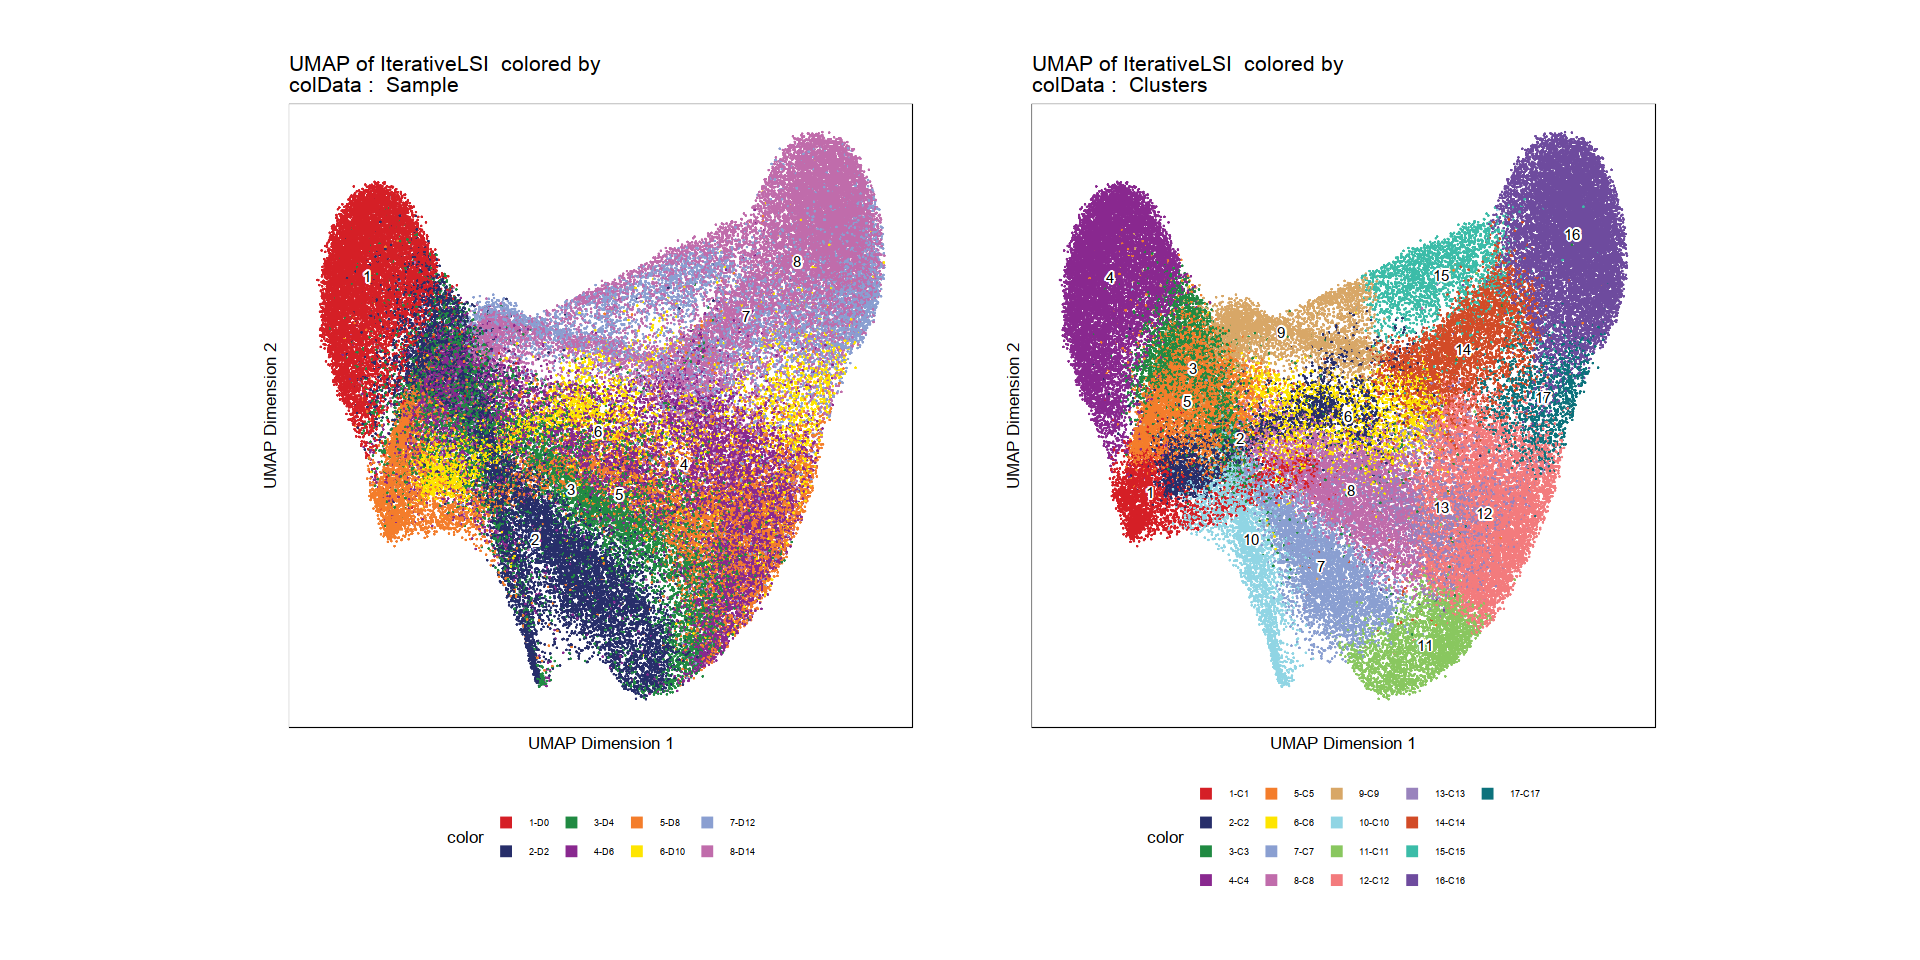

In [29]:
options(repr.plot.width = 16, repr.plot.height = 8)

p1 | p2

## Integration

In [92]:
archr_proj <- addGeneIntegrationMatrix(
    ArchRProj = archr_proj, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = rna,
    addToArrow = T,
    groupRNA = "seurat_clusters",
    nameCell = "predictedCell_Un",
    nameGroup = "predictedGroup_Un",
    nameScore = "predictedScore_Un"
#     force = T
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-732148a1f886-Date-2020-09-23_Time-11-27-49.log
If there is an issue, please report to github with logFile!

2020-09-23 11:27:50 : Running Seurat's Integration Stuart* et al 2019, 0.024 mins elapsed.

2020-09-23 11:27:53 : Checking ATAC Input, 0.076 mins elapsed.

2020-09-23 11:27:53 : Checking RNA Input, 0.077 mins elapsed.

2020-09-23 11:28:09 : Creating Integration Blocks, 0.336 mins elapsed.

2020-09-23 11:28:12 : Prepping Interation Data, 0.397 mins elapsed.

2020-09-23 11:28:18 : Computing Integration in 8 Integration Blocks!, 0 mins elapsed.

2020-09-23 11:36:05 : Transferring Data to ArrowFiles, 7.782 mins elapsed.

2020-09-23 11:38:53 : Completed Integration with RNA Matrix, 10.598 mins elapsed.

Overriding previous entry for predictedCell_Un

Overriding previous entry for predictedGroup_Un

Overriding previous entry for predictedScore_Un

ArchR logging successful to : ArchRLogs/ArchR-addGeneIntegrationMatrix-732148a1f

In [36]:
getAvailableMatrices(archr_proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


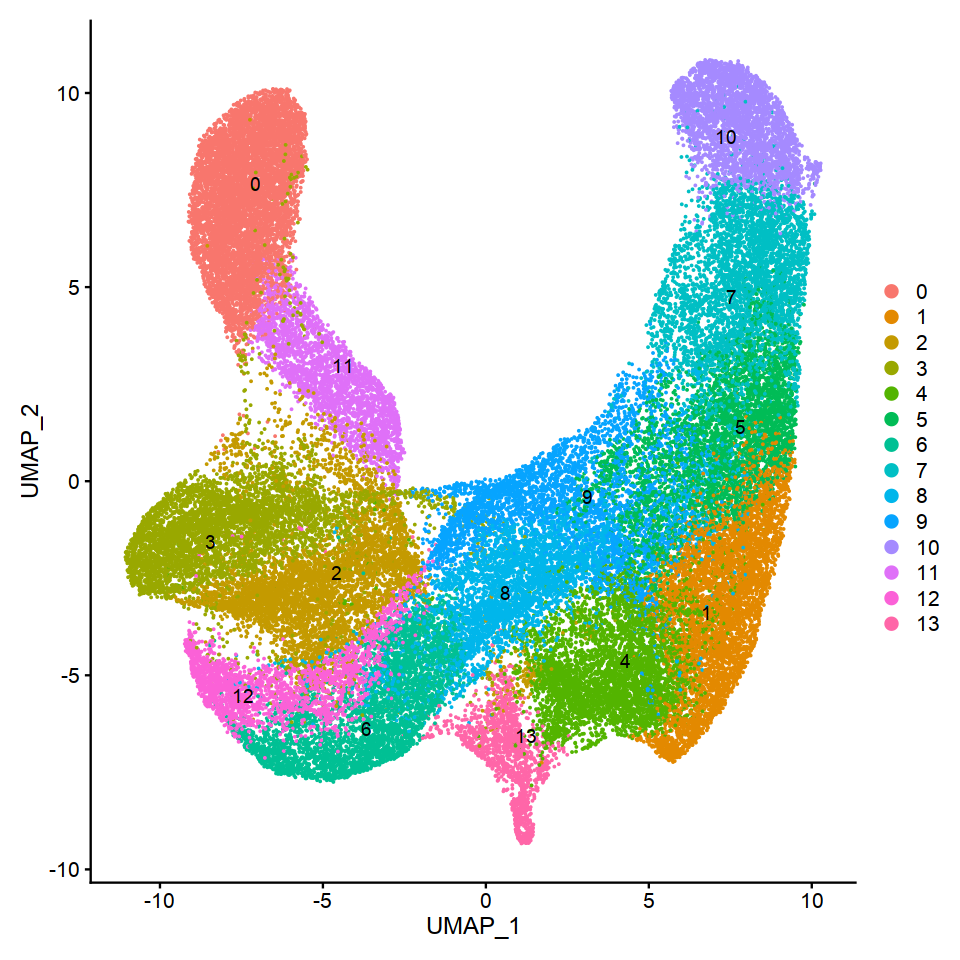

In [32]:
options(repr.plot.width = 8, repr.plot.height = 8)

DimPlot(rna, group.by="seurat_clusters", label=T, repel=T) 

In [31]:
cM <- as.matrix(confusionMatrix(archr_proj$Clusters, archr_proj$predictedGroup_Un))
preClust <- colnames(cM)[apply(cM, 1 , which.max)]
cbind(preClust, rownames(cM)) #Assignments

preClust    
 [1,] 0        C4 
 [2,] 3        C1 
 [3,] 2        C3 
 [4,] 3        C5 
 [5,] 6        C2 
 [6,] 9        C6 
 [7,] 12       C9 
 [8,] 4        C7 
 [9,] 10       C16
[10,] 4        C8 
[11,] 4        C11
[12,] 13       C10
[13,] 9        C14
[14,] 1        C12
[15,] 1        C13
[16,] 9        C15
[17,] 5        C17

In [73]:
head(rev(sort(table(archr_proj$predictedCell_Un))), 20)


CTGTACCAGGGTACAC-1 CACATGATCATGGATC-1 CTACCTGTCACACCCT-6 CATGCGGCAAAGAACT-1 
               496                423                352                340 
GCATCGGAGTTCCAGT-8 AACAAAGTCCATAGGT-1 AGGGTGACAGGCATTT-1 ATCAGGTAGTAACCGG-8 
               320                314                309                265 
AAAGGTAAGATTAGCA-6 GATCCCTCATTCGATG-1 TTAGGGTTCCAAGAGG-6 TGGTACAAGTCGAATA-1 
               250                245                239                233 
GTTACCCCACTACACA-7 TTGAACGTCTGTTGGA-1 TTGGTTTTCAGGCGAA-3 GCACGTGGTTATGGTC-1 
               220                216                215                215 
TCGGGTGCACATTCTT-6 GTGCAGCCAATAGGGC-2 CAGCAATAGGTTCATC-8 AATAGAGTCAGTCTTT-6 
               214                210                210                206 

In [86]:
BARCODE = "GTGCAGCCAATAGGGC-2"

In [87]:
umap_dims = archr_proj@embeddings$UMAP$df
colnames(umap_dims) = c("UMAP1", "UMAP2")
umap_dims$col = archr_proj$predictedCell_Un %in% c(BARCODE)
umap_dims$sz = ifelse(umap_dims$col, 10, 1)
umap_dims = umap_dims[order(umap_dims$sz), ]

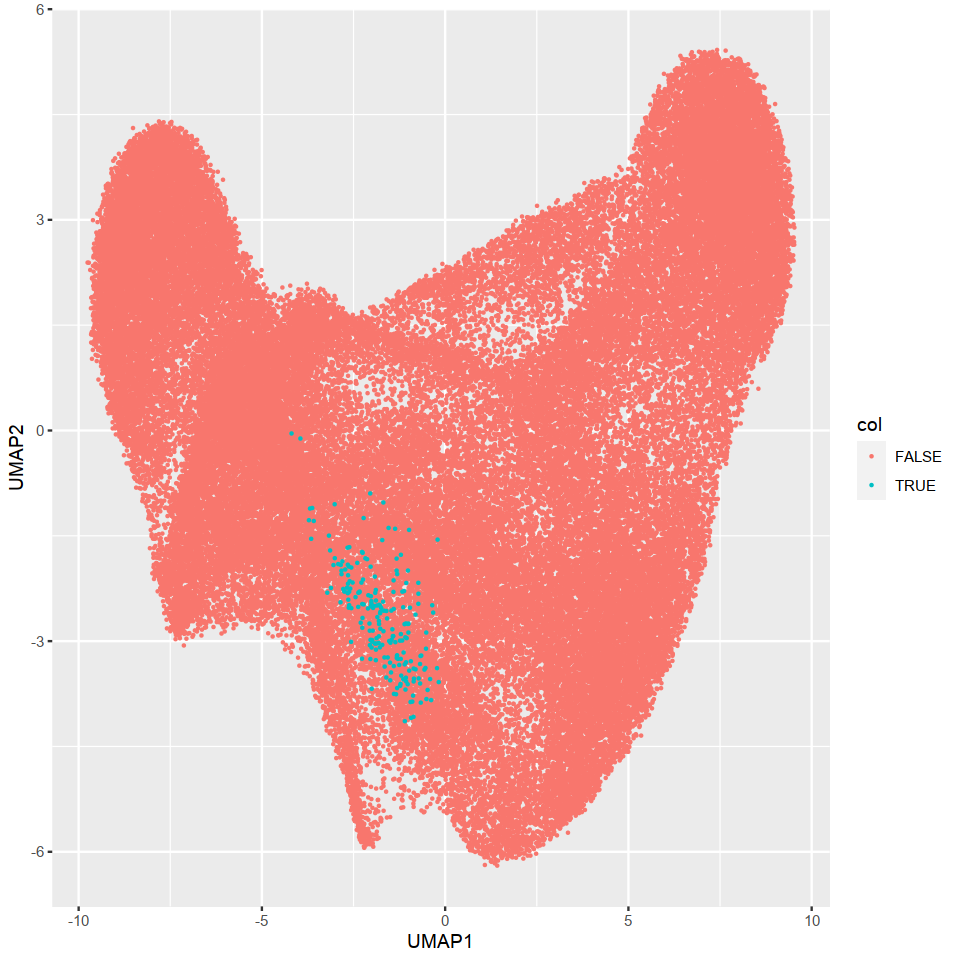

In [88]:
ggplot(umap_dims) + 
geom_point(aes(x=UMAP1, y=UMAP2, col=col), stroke=0, size=1)

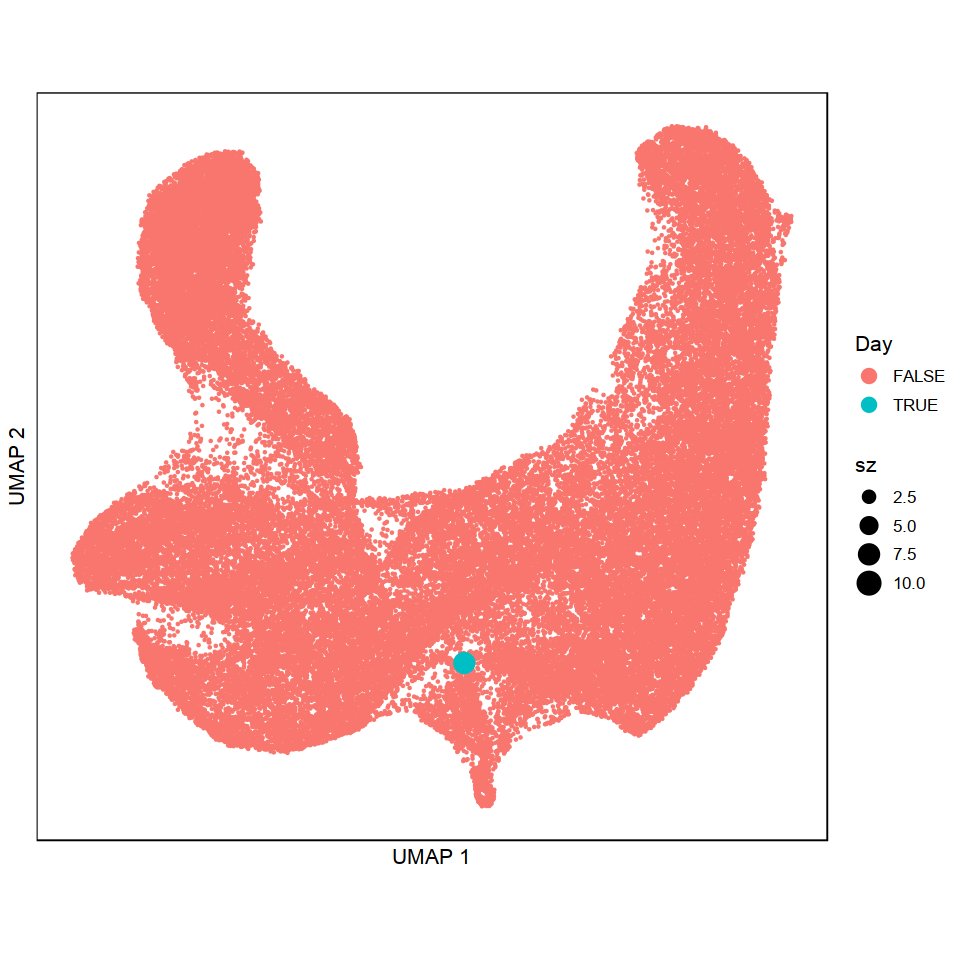

In [89]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
                 col=colnames(rna) %in% c(BARCODE))
plot_df$sz = ifelse(plot_df$col, 10, 1)
plot_df = plot_df[order(plot_df$sz), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=col, stroke=0, size=sz)) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4))) + 
coord_fixed()

by_day

In [93]:
archr_proj <- addPeak2GeneLinks(
    ArchRProj = archr_proj,
    reducedDims = "IterativeLSI"
)

ArchR logging to : ArchRLogs/ArchR-addPeak2GeneLinks-7321429994a3-Date-2020-09-23_Time-11-38-54.log
If there is an issue, please report to github with logFile!

2020-09-23 11:38:56 : Getting Available Matrices, 0.03 mins elapsed.

2020-09-23 11:39:07 : Filtered Low Prediction Score Cells (7132 of 76727, 0.093), 0.097 mins elapsed.

2020-09-23 11:39:13 : Computing KNN, 0.185 mins elapsed.

2020-09-23 11:39:14 : Identifying Non-Overlapping KNN pairs, 0.204 mins elapsed.

2020-09-23 11:39:16 : Identified 500 Groupings!, 0.24 mins elapsed.

2020-09-23 11:39:16 : Getting Group RNA Matrix, 0.242 mins elapsed.

2020-09-23 11:39:53 : Getting Group ATAC Matrix, 0.859 mins elapsed.

2020-09-23 11:41:53 : Normalizing Group Matrices, 2.861 mins elapsed.

2020-09-23 11:42:23 : Finding Peak Gene Pairings, 3.366 mins elapsed.

2020-09-23 11:42:25 : Computing Correlations, 3.387 mins elapsed.

2020-09-23 11:43:23 : Completed Peak2Gene Correlations!, 4.361 mins elapsed.

ArchR logging successful to : A

In [533]:
p2g <- getPeak2GeneLinks(
    ArchRProj = archr_proj,
    corCutOff = 0.45,
    FDRCutOff = 1e-04,
    resolution = 1,
    returnLoops = FALSE
)

In [536]:
head(p2g@metadata[[1]])

GRanges object with 6 ranges and 0 metadata columns:
      seqnames      ranges strand
         <Rle>   <IRanges>  <Rle>
  [1]     chr1 10506-10717      *
  [2]     chr1 42146-42371      *
  [3]     chr1 46218-46443      *
  [4]     chr1 48626-48825      *
  [5]     chr1 51437-51661      *
  [6]     chr1 51692-51930      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [538]:
p2g@metadata[[2]][p2g$idxRNA]

GRanges object with 149490 ranges and 2 metadata columns:
           seqnames    ranges strand |      name     idx
              <Rle> <IRanges>  <Rle> |   <array> <array>
       [1]     chr1    825138      * | LINC01128       2
       [2]     chr1    919692      * | LINC02593       5
       [3]     chr1    919692      * | LINC02593       5
       [4]     chr1    919692      * | LINC02593       5
       [5]     chr1    924880      * |    SAMD11       6
       ...      ...       ...    ... .       ...     ...
  [149486]     chrX 155147937      * |     MTCP1     690
  [149487]     chrX 155147937      * |     MTCP1     690
  [149488]     chrX 155071420      * |     BRCC3     691
  [149489]     chrX 155071420      * |     BRCC3     691
  [149490]     chrX 155197007      * |      VBP1     692
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [546]:
# write to file

p2g_df = data.frame(p2g)
p2g_df$peak = as.character(p2g@metadata[[1]][p2g$idxATAC])
p2g_df$gene = p2g@metadata[[2]][p2g$idxRNA]$name

p2g_df$idxATAC = NULL
p2g_df$idxRNA = NULL   

p2g_df = p2g_df[, c("peak", "gene", "Correlation", "FDR", "VarQATAC", "VarQRNA")]

head(p2g_df)

write.table(p2g_df, "../20200925_Peak2Gene/peak2gene_links/20200913_n27632/20200925_cor0.45.tsv",
           sep='\t', quote=F, col.names=T, row.names=F)

peak               gene      Correlation FDR          VarQATAC  VarQRNA  
1 chr1:998870-999115 LINC01128 0.5143508   1.379834e-33 0.9430070 0.4471862
2 chr1:817304-817603 LINC02593 0.4784177   1.422211e-28 0.9986056 0.3615493
3 chr1:923745-924044 LINC02593 0.4505192   4.453938e-25 0.9220954 0.3615493
4 chr1:943173-943379 LINC02593 0.4645768   8.473222e-27 0.8292050 0.3615493
5 chr1:817304-817603 SAMD11    0.7163478   2.897274e-77 0.9986056 0.7551148
6 chr1:817692-817947 SAMD11    0.6097022   2.890740e-50 0.8978268 0.7551148

In [596]:
length(unique(p2g_df$gene))

[1] 12866

In [597]:
length(unique(p2g_df$peak))

[1] 94071

In [603]:
median(table(p2g_df$gene))

[1] 8

In [128]:
head(rev(sort(table(p2g$idxATAC))))


732955 724792 739639 732936 732917 732916 
    14     14     13     13     13     13 

In [149]:
head(p2g@metadata[[2]])

GRanges object with 6 ranges and 2 metadata columns:
      seqnames    ranges strand |      name     idx
         <Rle> <IRanges>  <Rle> |   <array> <array>
  [1]     chr1    817371      * |    FAM87B       1
  [2]     chr1    825138      * | LINC01128       2
  [3]     chr1    827522      * | LINC00115       3
  [4]     chr1    876903      * |    FAM41C       4
  [5]     chr1    919692      * | LINC02593       5
  [6]     chr1    924880      * |    SAMD11       6
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [238]:
head(rev(sort(table(p2g@metadata[[2]][p2g$idxRNA]$name))), 30)


   COL6A3      MLPH     FOXF1    FENDRR     SMAD3    SEMA6A   RASGRP4     FOXL1 
      141       115       104        95        93        88        88        88 
     RYR1     GCNT2     TNNI3     PARVA      DKK3      TBX2      SYT5      NAV1 
       85        84        83        83        82        80        79        79 
    NLRP7    MICAL2     EIF3K     NLRP2    COL1A1   ZFP36L1    TNFSF9      RXRA 
       77        77        76        75        74        73        73        72 
    NANOG    MAP4K1     CECR2 LINC01081    LGALS1     HIPK2 
       72        72        72        71        70        70 

In [252]:
table(p2g@metadata[[2]][p2g$idxRNA]$name)["EPVR1"]

<NA> 
  NA

In [139]:
getPeak2GeneLinks(archr_proj)[[1]][queryHits(findOverlaps(getPeak2GeneLinks(archr_proj)[[1]], 
                                                          GRanges(c("chr12:7787794-7799141"))))]

GRanges object with 82 ranges and 2 metadata columns:
       seqnames          ranges strand |             value                  FDR
          <Rle>       <IRanges>  <Rle> |         <numeric>            <numeric>
   [1]    chr12 7667500-7891500      * |  0.55062494438884 2.68719331246967e-39
   [2]    chr12 7677500-7891500      * | 0.482594892547855 3.98821626156944e-29
   [3]    chr12 7678500-7891500      * | 0.497486498708443 3.69684621111592e-31
   [4]    chr12 7679500-7891500      * | 0.472772419885563 7.71042634745979e-28
   [5]    chr12 7693500-7891500      * | 0.594741248489826 2.85581593073272e-47
   ...      ...             ...    ... .               ...                  ...
  [78]    chr12 7787500-7982500      * | 0.468881731262359 2.42567986427967e-27
  [79]    chr12 7787500-8018500      * | 0.512509915437053 2.57785107855091e-33
  [80]    chr12 7787500-8019500      * | 0.664463158153499 9.80223350748262e-63
  [81]    chr12 7789500-7891500      * | 0.639733572190767 8.69238

In [530]:
p <- plotBrowserTrack(
    ArchRProj = archr_proj, 
    groupBy = "Clusters", 
    geneSymbol = c("MAP2"), 
    upstream = 50000,
    downstream = 400000,
    loops = getPeak2GeneLinks(archr_proj, resolution = 10000)[[1]]
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-732116307ef0-Date-2020-09-24_Time-11-44-30.log
If there is an issue, please report to github with logFile!

2020-09-24 11:44:33 : Validating Region, 0.041 mins elapsed.



GRanges object with 1 range and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr2 209424058-209734118      + |        4133        MAP2
  -------
  seqinfo: 24 sequences from hg38 genome


2020-09-24 11:44:33 : Adding Bulk Tracks (1 of 1), 0.042 mins elapsed.

2020-09-24 11:44:45 : Adding Feature Tracks (1 of 1), 0.25 mins elapsed.

2020-09-24 11:44:45 : Adding Loop Tracks (1 of 1), 0.252 mins elapsed.

2020-09-24 11:44:46 : Adding Gene Tracks (1 of 1), 0.256 mins elapsed.

2020-09-24 11:44:46 : Plotting, 0.26 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-732116307ef0-Date-2020-09-24_Time-11-44-30.log



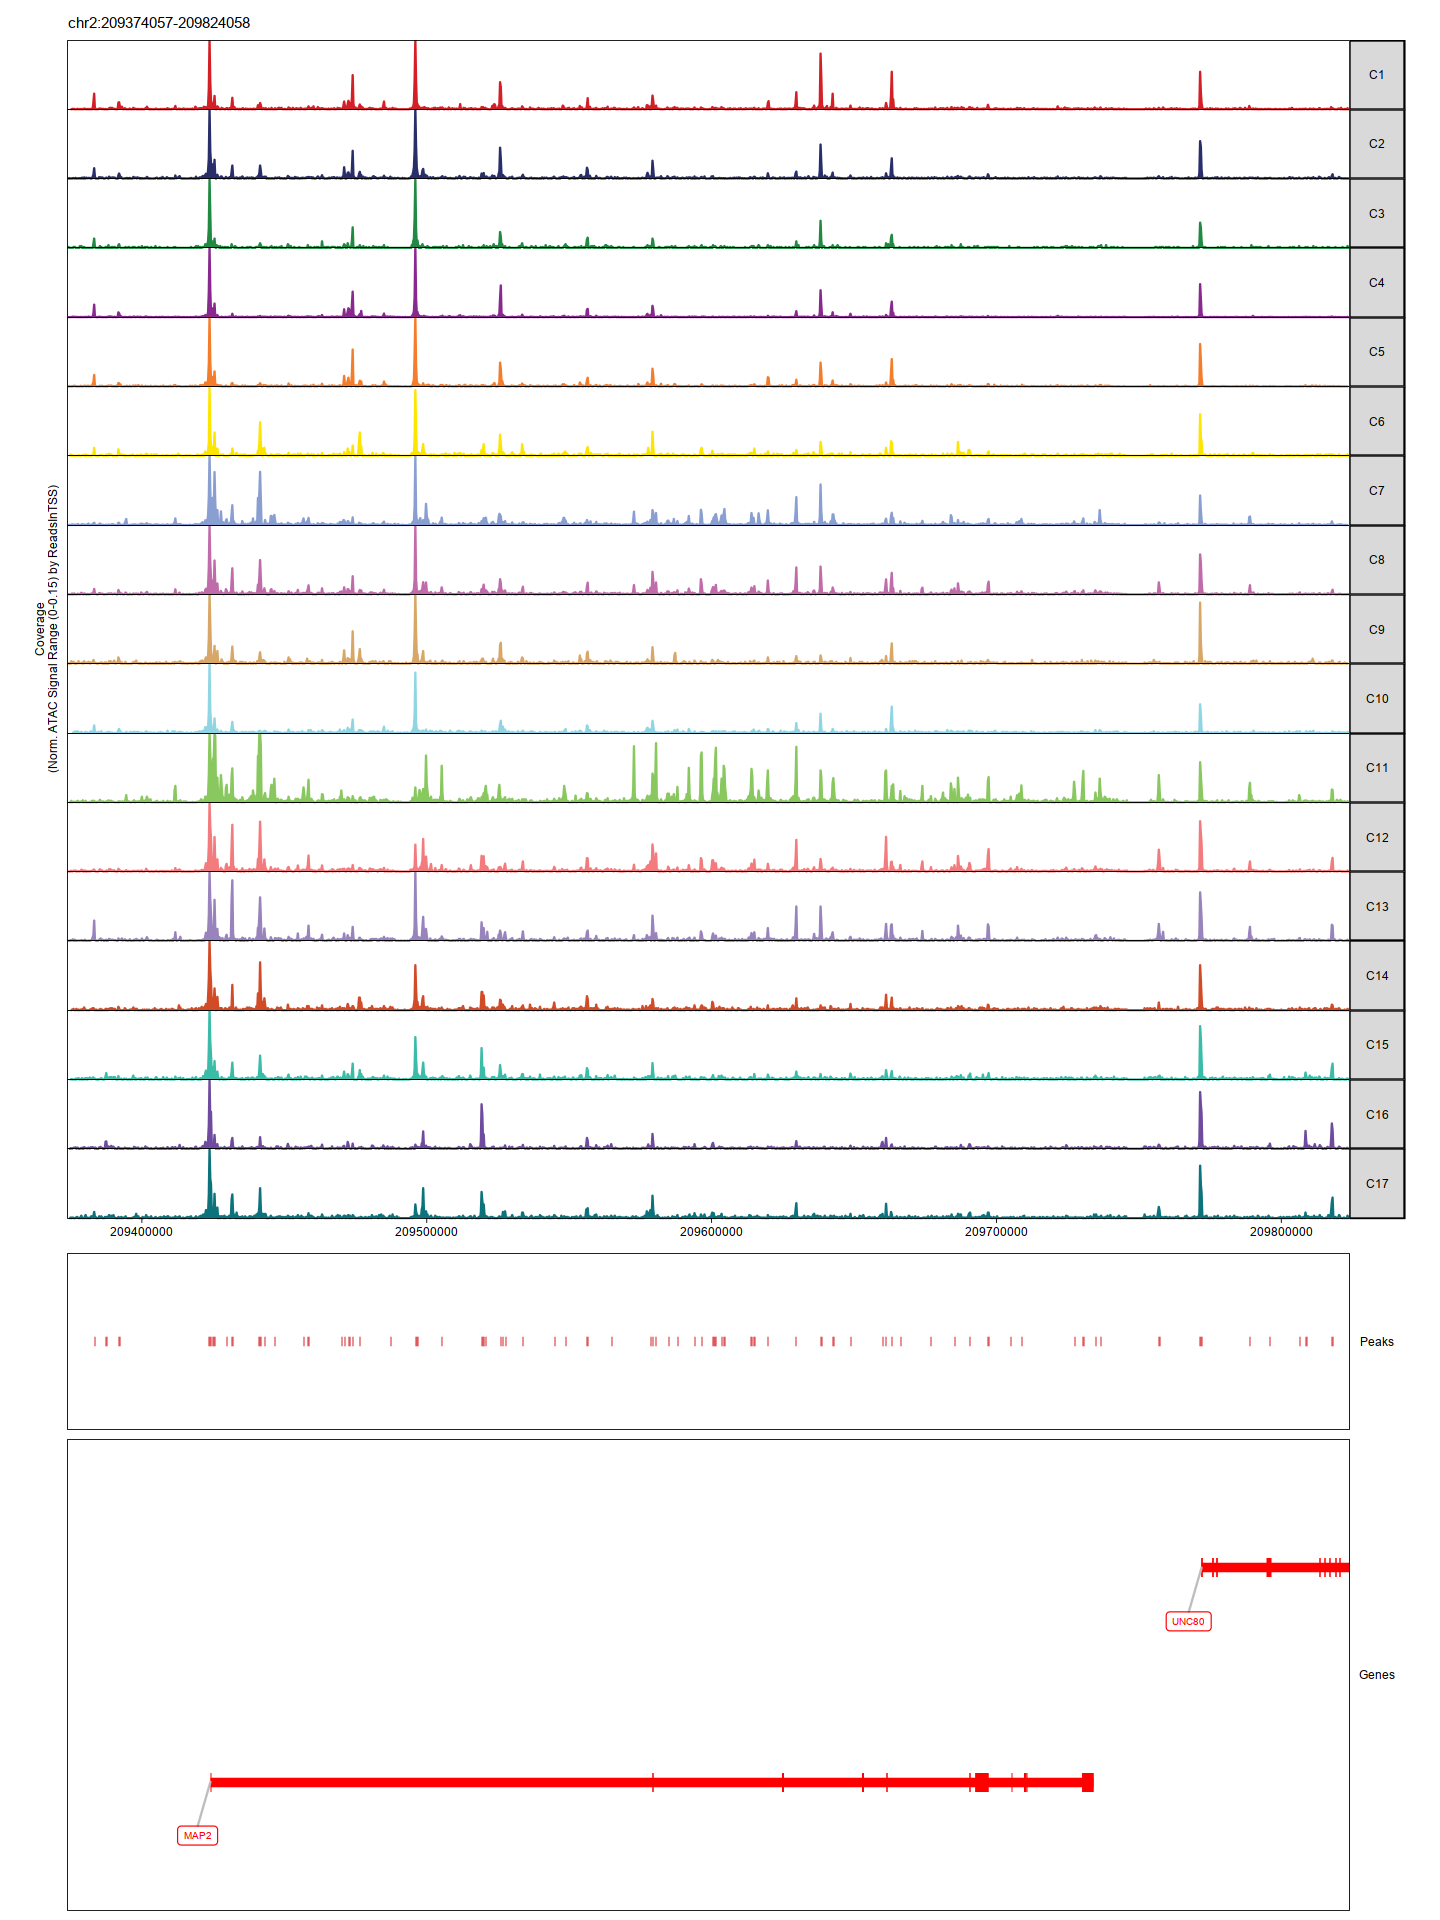

In [531]:
options(repr.plot.width = 12, repr.plot.height = 16)

grid::grid.newpage()
grid::grid.draw(p$MAP2)

In [100]:
p <- plotPeak2GeneHeatmap(ArchRProj = archr_proj, groupBy = "Clusters")

ArchR logging to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-732172634f49-Date-2020-09-23_Time-12-19-52.log
If there is an issue, please report to github with logFile!

2020-09-23 12:20:04 : Determining KNN Groups!, 0.198 mins elapsed.

2020-09-23 12:20:19 : Ordering Peak2Gene Links!, 0.448 mins elapsed.

Warning message:
“did not converge in 10 iterations”
2020-09-23 12:22:15 : Constructing ATAC Heatmap!, 2.384 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

2020-09-23 12:22:17 : Constructing RNA Heatmap!, 2.414 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-732172634f49-Date-2020-09-23_Time-12-19-52.log



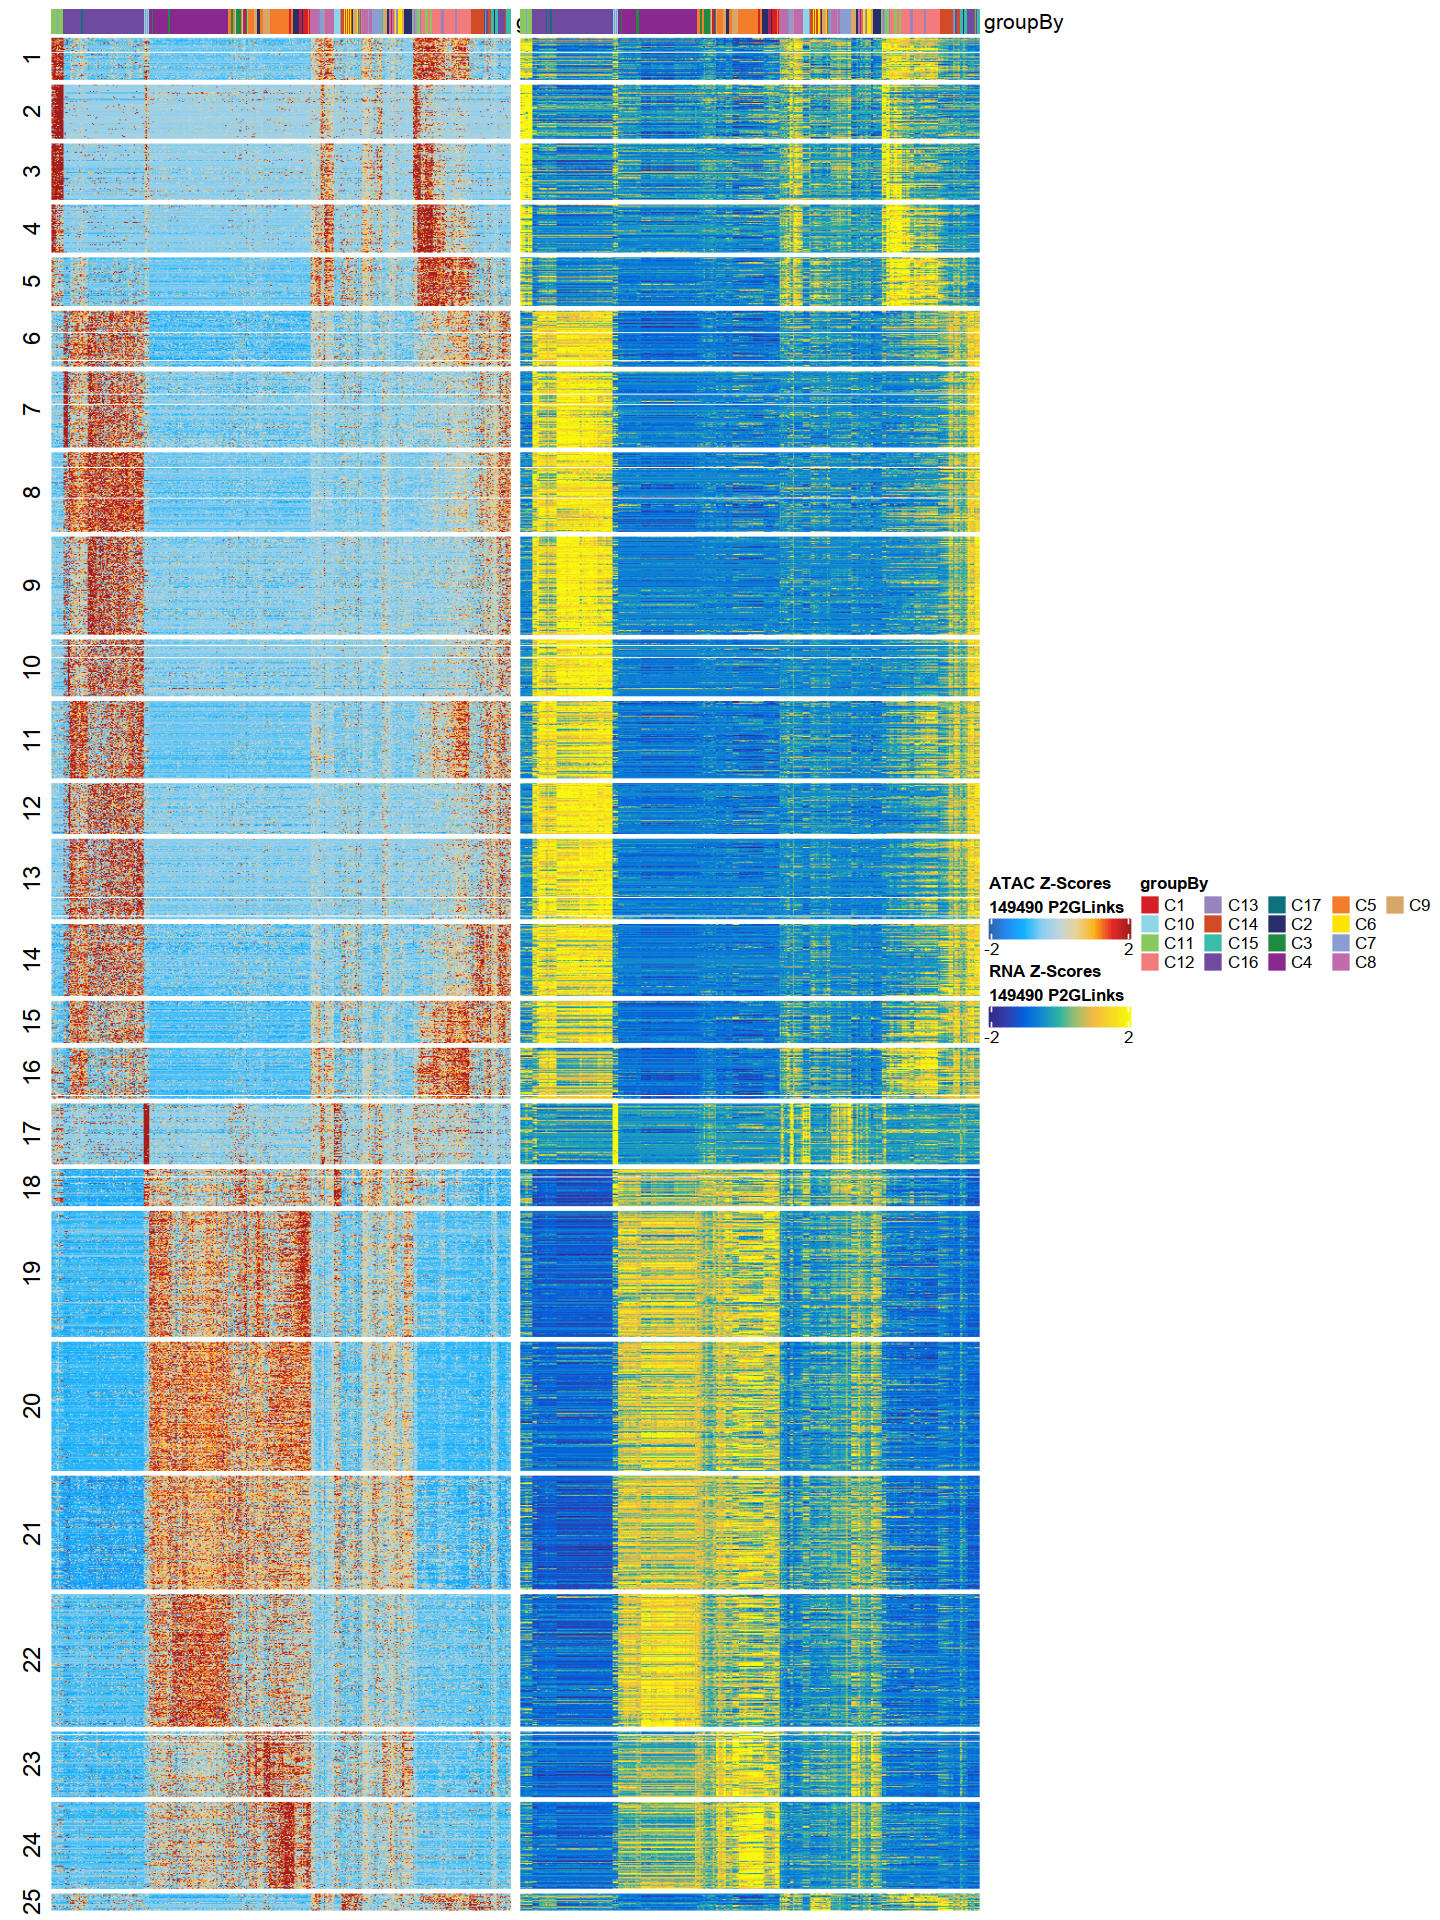

In [102]:
options(repr.plot.width = 12, repr.plot.height = 16)

p

In [258]:
p2g@metadata[[1]]

GRanges object with 803958 ranges and 1 metadata column:
           seqnames            ranges strand |  peak_set
              <Rle>         <IRanges>  <Rle> | <numeric>
       [1]     chr1       10506-10717      * |         0
       [2]     chr1       42146-42371      * |         0
       [3]     chr1       46218-46443      * |         0
       [4]     chr1       48626-48825      * |         0
       [5]     chr1       51437-51661      * |         0
       ...      ...               ...    ... .       ...
  [803954]     chrY 25399178-25399400      * |         0
  [803955]     chrY 26315152-26315361      * |         0
  [803956]     chrY 26409423-26409622      * |         0
  [803957]     chrY 26671003-26671239      * |         0
  [803958]     chrY 26671290-26671489      * |         0
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [287]:
p2g@metadata[[1]]$peak_set = 0
all_peak_str = as.character(p2g@metadata[[1]]) # sorted version of peak_set

for (i in seq(40)) {
    cur_peak_set = import(sprintf("../20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/idx%d.bed", i))
    p2g@metadata[[1]][all_peak_str %in% as.character(cur_peak_set)]$peak_set = i
}

In [514]:
SELECT_PEAK_SETS = c(33,34,35)

In [515]:
idxs = which(p2g@metadata[[1]]$peak_set %in% SELECT_PEAK_SETS)

In [516]:
length(idxs)

[1] 41689

In [517]:
sum(p2g$idxATAC %in% idxs)

[1] 10289

In [518]:
p2g@metadata[[2]][p2g[p2g$idxATAC %in% idxs, ][rev(order(p2g[p2g$idxATAC %in% idxs, ]$Correlation)),]$idxRNA]

GRanges object with 10289 ranges and 2 metadata columns:
          seqnames    ranges strand |    name     idx
             <Rle> <IRanges>  <Rle> | <array> <array>
      [1]     chr1 161038962      * |    F11R    1365
      [2]     chr3  11137093      * |    HRH1      61
      [3]    chr17  48593961      * |   HOXB5     698
      [4]    chr17  48604992      * |   HOXB6     696
      [5]     chr2 238848032      * |  TWIST2    1244
      ...      ...       ...    ... .     ...     ...
  [10285]     chr7  24758113      * |   GSDME     126
  [10286]    chr10  97334709      * |   FRAT2     494
  [10287]     chr1 109283186      * |   PSRC1     949
  [10288]    chr16    684528      * |   JMJD8      37
  [10289]     chr5  38608354      * |    LIFR     124
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [519]:
cor_genes = rev(sort(table(p2g@metadata[[2]][p2g[p2g$idxATAC %in% idxs, ]$idxRNA]$name)))
length(cor_genes)
head(cor_genes, 20)

[1] 4528


    GAMT   MALAT1   FAM89B CDC42EP2    MXRA8   SHKBP1   LGALS1    ERCC1 
      24       17       17       16       15       14       14       14 
   CIRBP  CCDC85B  TRAPPC1    LZTS2     LMNA     FIBP    TIMP2   SORBS3 
      14       14       13       13       13       13       12       12 
  PDLIM2    NEAT1     LTBR    GAPDH 
      12       12       12       12 

In [520]:
# genes ranked by correlation to their linked peak
# cor_genes_by_cor = p2g[p2g$idxATAC %in% idxs, ]
# cor_genes_by_cor = p2g@metadata[[2]][cor_genes_by_cor[rev(order(cor_genes_by_cor$Correlation)),]$idxRNA]$name
# cor_genes_by_cor = unique(cor_genes_by_cor)
# length(cor_genes_by_cor)
# head(cor_genes_by_cor, 10)

In [521]:
sum(cor_genes>1)

[1] 2312

In [524]:
cor_genes["CTCFL"]

CTCFL 
    1

In [513]:
write.table(names(cor_genes)[1:2000], "tmp.txt", quote=F, row.names=F, col.names=F)

In [478]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

hiF.T_P14 X2dd_DOX_plus X5dd_DOX_plus X8dd_DOX_plus
GAPDH 7803.64   4963.505      3908.693      3839.776     
      X10dd_DOX_plus_SSEA3_pos X14dd_DOX_plus_SSEA3_pos X20dd_DOX_plus_TRA_plus
GAPDH 3795.548                 3364.503                 3032.412               
      X24dd_TRA_pos_DOX_plus X24dd_TRA_pos_DOX_minus hIPSC.T_P10
GAPDH 3790.955               5598.224                4731.256

Warning message in melt(as.matrix(log2(1 + tpm)[rownames(tpm) %in% cor_genes_by_cor[1:100], :
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(log2(1 + tpm)[rownames(tpm) %in% cor_genes_by_cor[1:100],     ])). In the next version, this warning will become an error.”


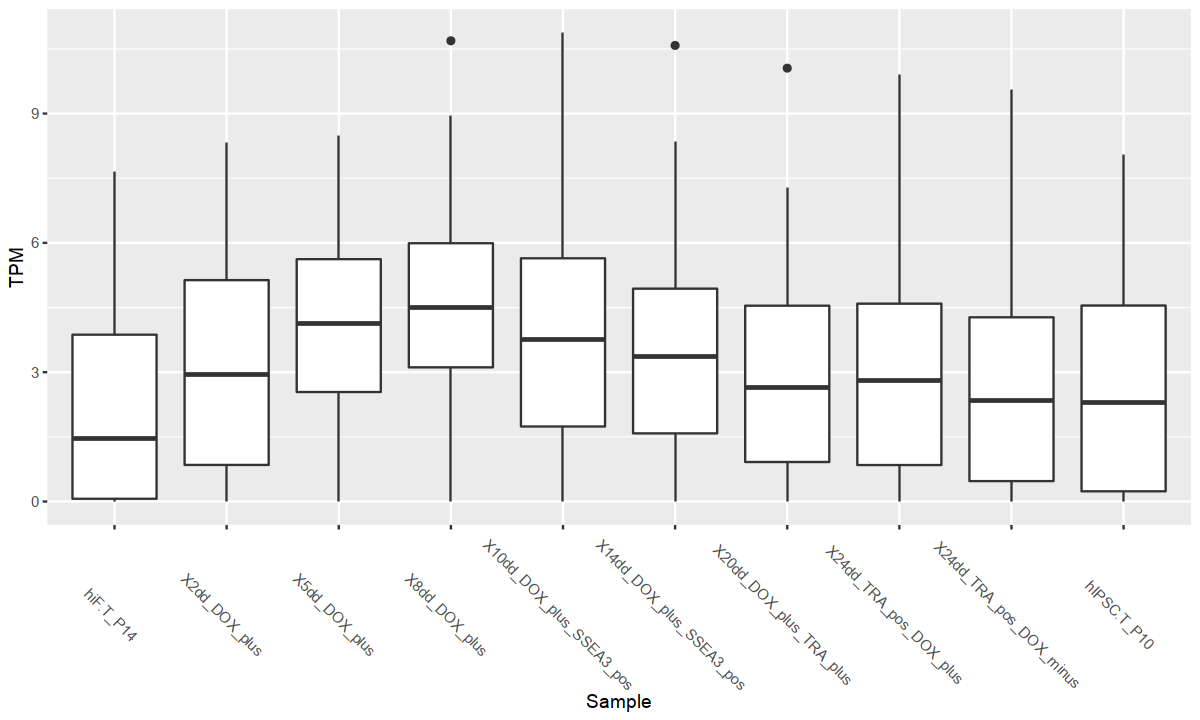

In [498]:
options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(melt(as.matrix(log2(1+tpm)[rownames(tpm) %in% names(cor_genes)[1:100], ])), aes(x=Var2, y=value)) +
# ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% names(cor_genes)[1:100], ])))), aes(x=Var2, y=value)) +
stat_boxplot() +
# geom_line(aes(group=Var1),size=0.1) + geom_point() +
theme(axis.text.x = element_text(angle = -45)) +
ylab("TPM") + xlab("Sample")
# geom_boxplot(outlier.shape = NA) + geom_jitter(width = 0.2)
# coord_cartesian(ylim=c(0,8))